## Analyzing Smart Home Data

#### Smart Fridge Data

Importing Libraries

In [1]:
import pandas as pd
import sys
from scapy.all import *
import pickle
import datetime
import os
import ipaddress
import netaddr
import numpy as np

Reused Functions from Noise Lab Ml-Networking

In [2]:
def pcap_to_dict(pcap_file):
    '''Parses a pickle file into a list of dicts.
    Arguments:
      pcap_file: string filepath of pcap file
    Returns:
      List of dicts with one dict per packet in pcap file.
        The dicts have the following key/value pairs:
          "time"     : time the packet was receieved in seconds since epoch
          "datetime" : time the packet was received as a datetime object
          "length"   : length of packet in bytes
          "mac_src"  : source MAC address
          "mac_dst"  : destination MAC address
          "ip_src"   : source IP address
          "ip_dst"   : destination IP address
          "protocol" : 'TCP', 'UDP', 'ICMP', or None
          "port_src" : source port
          "port_dst" : destination port
          "is_dns"   : True if packet is DNS packet, else False
          "dns_query" : string DNS query
          "dns_resp" : string DNS response
    '''
    data = []
    with PcapReader(pcap_file) as pcap_reader:
        for i, pkt in enumerate(pcap_reader):
            pkt_dict = {}
            #if i % 1000 == 0 and i != 0: print(i)
            try:
                if Ether not in pkt:
                    continue
                
                pkt_dict["time"] = pkt.time
                pkt_dict["datetime"] = datetime.datetime.fromtimestamp(pkt.time)
                pkt_dict["length"] = len(pkt)
                pkt_dict["mac_dst"] = pkt[Ether].dst
                pkt_dict["mac_src"] = pkt[Ether].src
                pkt_dict["ip_dst"] = None
                pkt_dict["ip_src"] = None
                pkt_dict["protocol"] = None
                pkt_dict["port_dst"] = None
                pkt_dict["port_src"] =  None
                pkt_dict["is_dns"] = False
                pkt_dict["dns_query"] = None
                pkt_dict["dns_resp"] = None
                
                if IP in pkt:
                    pkt_dict["ip_dst"] = pkt[IP].dst
                    pkt_dict["ip_src"] = pkt[IP].src
                                
                if TCP in pkt:
                    pkt_dict["port_dst"] = pkt[TCP].dport
                    pkt_dict["port_src"] = pkt[TCP].sport
                    pkt_dict["protocol"] = 'TCP'
                elif UDP in pkt:
                    pkt_dict["port_dst"] = pkt[UDP].dport
                    pkt_dict["port_src"] = pkt[UDP].sport
                    pkt_dict["protocol"] = 'UDP'
                elif ICMP in pkt:
                    pkt_dict["protocol"] = 'ICMP'
                    
                if DNSQR in pkt:
                    pkt_dict["is_dns"] = True
                    pkt_dict["dns_query"] = pkt[DNSQR].qname
                if DNSRR in pkt:
                    pkt_dict["is_dns"] = True
                    pkt_dict["dns_resp"] = pkt[DNSRR].rrname
                
                data.append(pkt_dict)
            except:
                continue
    return data


In [3]:
def pcap_to_pandas(pcap_file):
    '''Parses pcap file into pandas DataFrame.
    Arguments:
        pcap_file: string filepath of pcap file
    Returns:
      DataFrame with one packet per row
        column names are the keys from pcap_to_dict plus
        'ip_dst_int', 'ip_src_int', 'mac_dst_int', 'mac_dst_int'
    '''
    data = pcap_to_dict(pcap_file)
    pd_data = pd.DataFrame(data)
    pd_data["datetime"] = pd_data["datetime"].apply(lambda x: np.datetime64(x))
    pd_data["datetime"] = pd.to_datetime(pd_data['datetime'])
    pd_data['ip_dst_int'] = pd_data['ip_dst'].apply(
        lambda x: None if x is None else int(ipaddress.ip_address(x)))
    pd_data['ip_src_int'] = pd_data['ip_src'].apply(
        lambda x: None if x is None else int(ipaddress.ip_address(x))) 
    pd_data["mac_dst_int"] = pd_data["mac_dst"].apply(
        lambda x: None if x is None else int(netaddr.EUI(x)))
    pd_data["mac_src_int"] = pd_data["mac_src"].apply(
        lambda x: None if x is None else int(netaddr.EUI(x)))
    pd_data["time_normed"] = pd_data["time"].apply(
        lambda x: x - pd_data.iloc[0]['time'])
    pd_data = pd_data.sort_index(axis=1)
    return pd_data

In [4]:
def parse_and_save_pcap(pcap_file, pickle_file):
    '''Parses pcap file and saves results as a compressed pickle file.
    Arguments:
      pcap_file: path of pcap file
      pickle_file: path to sae pickle file
    '''
    data = pcap_to_pandas(pcap_file)
    data.to_pickle(pickle_file)
    
        
def load_parsed_pcap(pickle_file):
    '''Reads already parsed pickle file back into memory.
    Arguments:
      pickle_file: path to pickle file saved by parse_and_save_pcap()
    
    Returns:
      pandas dataframe in the format created by pcap_to_pandas()
    '''
    data = pd.read_pickle(pickle_file)
    return data

In [5]:
def send_rates(data, window_len_sec):
    '''Calculates send rates from packet DataFrames
    Arguments:
      data: pandas DataFrame with 'time' and 'length' columns 
              like that returned from pcap_to_pandas()
      window_len_sec: interval for calculating rates
    Returns:
       rates: array of send rates
       times: array of times corresponding to each window in rates
    '''
    data = data.sort_values(by=["time"])
    windows = []
    times = []
    curr_time = data.iloc[0]["time"]
    end_time = curr_time + window_len_sec
    i = 0
    while curr_time < data.iloc[-1]["time"]:
        windows.append(0)
        times.append(curr_time)
        while i < len(data) and data.iloc[i]["time"] < end_time:
            windows[-1] += data.iloc[i]["length"]
            i += 1
        curr_time = end_time
        end_time = curr_time + window_len_sec
    rates = np.array(windows) / float(window_len_sec)
    times = np.array(times)
    return rates, times

In [ ]:
import datetime

categories = ['INACTIVE', 'WEB', 'AUDIO', 'VIDEO', 'GAMING']

inp = input("Clear? Y/N\n")

if inp in ["y", "Y"]:
	with open('log.txt', 'w') as f:
		f.write("")

while True:
	for i, c in enumerate(categories):
		print("{}: {}".format(i, c))
	cat = input()
	print("\n")
	time = datetime.datetime.now()
	with open('log.txt', 'a') as f:
		f.write(str(time) + '\n' + str(cat) + '\n')

##### 0 - Basic Packet Capture Analysis

In [6]:
#Looking at the first 5 rows of the packet capture
pcap = pcap_to_pandas('fridge_door1.pcap')
pcap.head(5)

,datetime,dns_query,dns_resp,ip_dst,ip_dst_int,ip_src,ip_src_int,is_dns,length,mac_dst,mac_dst_int,mac_src,mac_src_int,port_dst,port_src,protocol,time,time_normed
0,2020-02-24 16:12:37,None,None,None,NaN,None,NaN,False,60,ff:ff:ff:ff:ff:ff,281474976710655,70:2c:1f:39:25:6e,123334804710766,NaN,NaN,None,1582582357.305639,0.000000
1,2020-02-24 16:12:37,None,None,None,NaN,None,NaN,False,42,70:2c:1f:39:25:6e,123334804710766,00:04:4b:e4:08:c5,18453104837,NaN,NaN,None,1582582357.305749,0.000110
2,2020-02-24 16:12:41,None,None,None,NaN,None,NaN,False,42,70:2c:1f:39:25:6e,123334804710766,00:04:4b:e4:08:c5,18453104837,NaN,NaN,None,1582582361.036254,3.730615
3,2020-02-24 16:12:41,None,None,None,NaN,None,NaN,False,60,00:04:4b:e4:08:c5,18453104837,70:2c:1f:39:25:6e,123334804710766,NaN,NaN,None,1582582361.114276,3.808637
4,2020-02-24 16:12:48,None,None,52.14.6.98,873334370.0,192.168.143.43,3.232272e+09,False,307,00:04:4b:e4:08:c5,18453104837,70:2c:1f:39:25:6e,123334804710766,443.0,43824.0,TCP,1582582368.237287,10.931648


In [7]:
#Looking at the amount of rows and columns in dataset and list of column names
print('{}\n\n'.format(pcap.shape))
print(pcap.columns)

(255, 18)


Index(['datetime', 'dns_query', 'dns_resp', 'ip_dst', 'ip_dst_int', 'ip_src',
       'ip_src_int', 'is_dns', 'length', 'mac_dst', 'mac_dst_int', 'mac_src',
       'mac_src_int', 'port_dst', 'port_src', 'protocol', 'time',
       'time_normed'],
      dtype='object')


In [8]:
#Looking at specific columns for the first 10 rows of the packet capture
pcap = pcap.loc[:,['datetime','ip_src','ip_dst',
                   'length','port_src','port_dst','protocol']]
pcap.head(10)

,datetime,ip_src,ip_dst,length,port_src,port_dst,protocol
0,2020-02-24 16:12:37,None,None,60,NaN,NaN,None
1,2020-02-24 16:12:37,None,None,42,NaN,NaN,None
2,2020-02-24 16:12:41,None,None,42,NaN,NaN,None
3,2020-02-24 16:12:41,None,None,60,NaN,NaN,None
4,2020-02-24 16:12:48,192.168.143.43,52.14.6.98,307,43824.0,443.0,TCP
5,2020-02-24 16:12:48,52.14.6.98,192.168.143.43,66,443.0,43824.0,TCP
6,2020-02-24 16:12:48,192.168.143.43,52.14.6.98,174,43824.0,443.0,TCP
7,2020-02-24 16:12:48,52.14.6.98,192.168.143.43,66,443.0,43824.0,TCP
8,2020-02-24 16:12:50,192.168.143.43,52.196.247.117,116,58496.0,5223.0,TCP
9,2020-02-24 16:12:50,52.196.247.117,192.168.143.43,112,5223.0,58496.0,TCP


In [9]:
#Looking at rows with a specific IP address
pcap[pcap['ip_src'] == '192.168.143.43'].head(10)

,datetime,ip_src,ip_dst,length,port_src,port_dst,protocol
4,2020-02-24 16:12:48,192.168.143.43,52.14.6.98,307,43824.0,443.0,TCP
6,2020-02-24 16:12:48,192.168.143.43,52.14.6.98,174,43824.0,443.0,TCP
8,2020-02-24 16:12:50,192.168.143.43,52.196.247.117,116,58496.0,5223.0,TCP
10,2020-02-24 16:12:50,192.168.143.43,52.196.247.117,66,58496.0,5223.0,TCP
11,2020-02-24 16:12:50,192.168.143.43,224.0.0.251,243,5353.0,5353.0,UDP
12,2020-02-24 16:12:51,192.168.143.43,52.14.6.98,308,43824.0,443.0,TCP
14,2020-02-24 16:12:51,192.168.143.43,52.14.6.98,176,43824.0,443.0,TCP
16,2020-02-24 16:12:51,192.168.143.43,224.0.0.251,243,5353.0,5353.0,UDP
19,2020-02-24 16:12:59,192.168.143.43,8.8.8.8,80,58663.0,53.0,UDP
20,2020-02-24 16:12:59,192.168.143.43,8.8.8.8,80,59321.0,53.0,UDP


In [10]:
#Looking at unique destinations for the network traffic
unique_dst_ip = pd.DataFrame(pcap['ip_dst'].unique())[0]
print(unique_dst_ip)

0              None
1        52.14.6.98
2    192.168.143.43
3    52.196.247.117
4       224.0.0.251
5           8.8.8.8
6     52.25.218.231
Name: 0, dtype: object


In [11]:
#Looking at the most popular destination IP addresses
pkts_dst = pcap.loc[:,['datetime','ip_dst','length']]
pkts_dst.groupby(['ip_dst']).sum().sort_values(by='length',ascending=False)

,length
ip_dst,
52.25.218.231,301606
192.168.143.43,36972
52.14.6.98,965
224.0.0.251,486
52.196.247.117,182
8.8.8.8,160


In [12]:
from dns import resolver
from dns import reversename

#Test reverse DNS lookup
addr = reversename.from_address('34.193.201.2')
print(resolver.resolve(addr, "PTR")[0])

ec2-34-193-201-2.compute-1.amazonaws.com.


In [13]:
#Test reverse DNS lookup
addr = reversename.from_address('204.80.104.218')
print(resolver.resolve(addr, "PTR")[0])

zoomnye218mmr.ny.zoom.us.


In [14]:
#Reverse Lookup function
def reverse_lookup(ip):
    if str(ip) == 'None':
        return 'None'
    addr = reversename.from_address(ip)
    try:
        return str(resolver.resolve(addr, "PTR")[0])
    except Exception as e:
        return 'N/A'

In [15]:
#Looking at unique IP addresses
pcap['name_dst'] = pcap['ip_dst'].apply(reverse_lookup)
unique_dst_name = pd.DataFrame(pcap['name_dst'].unique())[0]
print(unique_dst_name)

0                                                 None
1      ec2-52-14-6-98.us-east-2.compute.amazonaws.com.
2                                                  N/A
3    ec2-52-196-247-117.ap-northeast-1.compute.amaz...
4                                          dns.google.
5    ec2-52-25-218-231.us-west-2.compute.amazonaws....
Name: 0, dtype: object


In [16]:
#Functions for the amount of volume sent to each IP address or name
def volume_stats_by_ip(pcap):
    return pcap.loc[:,['ip_dst','length']].groupby('ip_dst').sum().sort_values(by=['length'], ascending=False)


def volume_stats_by_name(pcap):
    return pcap.loc[:,['name_dst','length']].groupby('name_dst').sum().sort_values(by=['length'], ascending=False)

In [17]:
volume_stats_by_ip(pcap)

,length
ip_dst,
52.25.218.231,301606
192.168.143.43,36972
52.14.6.98,965
224.0.0.251,486
52.196.247.117,182
8.8.8.8,160


In [18]:
volume_stats_by_name(pcap)

,length
name_dst,
ec2-52-25-218-231.us-west-2.compute.amazonaws.com.,301606
N/A,37458
ec2-52-14-6-98.us-east-2.compute.amazonaws.com.,965
None,408
ec2-52-196-247-117.ap-northeast-1.compute.amazonaws.com.,182
dns.google.,160


##### 4 - Nearest Neighbors Trees

Importing Libraries

In [19]:
import numpy as np
import pandas as pd

import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime as dt

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (8,6)

In [20]:
#Converting data to points
pcap = pcap_to_pandas('fridge_door1.pcap') # this can take a few minutes
pcap.head(4)

,datetime,dns_query,dns_resp,ip_dst,ip_dst_int,ip_src,ip_src_int,is_dns,length,mac_dst,mac_dst_int,mac_src,mac_src_int,port_dst,port_src,protocol,time,time_normed
0,2020-02-24 16:12:37,None,None,None,NaN,None,NaN,False,60,ff:ff:ff:ff:ff:ff,281474976710655,70:2c:1f:39:25:6e,123334804710766,NaN,NaN,None,1582582357.305639,0.000000
1,2020-02-24 16:12:37,None,None,None,NaN,None,NaN,False,42,70:2c:1f:39:25:6e,123334804710766,00:04:4b:e4:08:c5,18453104837,NaN,NaN,None,1582582357.305749,0.000110
2,2020-02-24 16:12:41,None,None,None,NaN,None,NaN,False,42,70:2c:1f:39:25:6e,123334804710766,00:04:4b:e4:08:c5,18453104837,NaN,NaN,None,1582582361.036254,3.730615
3,2020-02-24 16:12:41,None,None,None,NaN,None,NaN,False,60,00:04:4b:e4:08:c5,18453104837,70:2c:1f:39:25:6e,123334804710766,NaN,NaN,None,1582582361.114276,3.808637


In [21]:
#device MAC address for a single device of interest
device_mac_address = '70:2c:1f:39:25:6e' 

#column name (as string) to compare to device_mac_addresses
device_packets = pcap[pcap['mac_src'] == device_mac_address] 

#Remove all non-IP packets
ip_packets = device_packets.loc[device_packets['ip_src'].notnull()]
ip_packets = ip_packets[ip_packets['ip_src'] != '0.0.0.0']
ip_packets = ip_packets[ip_packets['ip_dst'] != '0.0.0.0']

#select only the 'time' and 'length' columns
time_packets = ip_packets[['time', 'length']]
time_packets.head(5)

,time,length
4,1582582368.237287,307
6,1582582368.308095,174
8,1582582370.110944,116
10,1582582370.263880,66
11,1582582370.744682,243


In [22]:
#Making time more readable
time_packets['datetime'] = [dt.fromtimestamp(t) for t in time_packets['time']]
time_packets.head(3)

,time,length,datetime
4,1582582368.237287,307,2020-02-24 16:12:48
6,1582582368.308095,174,2020-02-24 16:12:48
8,1582582370.110944,116,2020-02-24 16:12:50


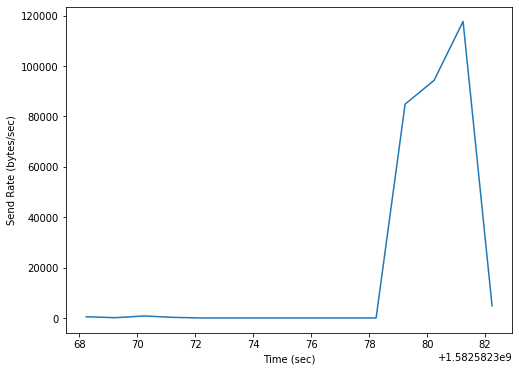

In [23]:
# Define the bin size over which to compute rates
sampling_interval_sec = 1

# Compute the send rates and the time for each bin.
rates, rate_times = send_rates(time_packets, sampling_interval_sec)

plt.plot(rate_times, rates)
plt.ylabel("Send Rate (bytes/sec)")
plt.xlabel("Time (sec)")
plt.show()
#Total amount of data sent over equal lengths of time 

#### Smart Lamp ? Data

##### 0 - Basic Packet Capture Analysis

In [45]:
#Not sure what happened with the datetime

In [43]:
#Looking at the first 10 rows of the packet capture
pcap = pcap_to_pandas('home.pcap')
pcap.head(10)

,datetime,dns_query,dns_resp,ip_dst,ip_dst_int,ip_src,ip_src_int,is_dns,length,mac_dst,mac_dst_int,mac_src,mac_src_int,port_dst,port_src,protocol,time,time_normed
0,2017-12-07 14:48:41,None,None,None,NaN,None,NaN,False,113,a4:77:33:2f:e0:6e,180831866839150,b8:27:eb:2d:24:15,202481588839445,NaN,NaN,None,1512679721.156083,0.000000
1,2017-12-07 14:48:41,None,None,None,NaN,None,NaN,False,135,b8:27:eb:2d:24:15,202481588839445,a4:77:33:2f:e0:6e,180831866839150,NaN,NaN,None,1512679721.255304,0.099221
2,2017-12-07 14:48:41,None,None,None,NaN,None,NaN,False,169,a4:77:33:2f:e0:6e,180831866839150,b8:27:eb:2d:24:15,202481588839445,NaN,NaN,None,1512679721.256350,0.100267
3,2017-12-07 14:48:41,None,None,None,NaN,None,NaN,False,113,b8:27:eb:2d:24:15,202481588839445,a4:77:33:2f:e0:6e,180831866839150,NaN,NaN,None,1512679721.300373,0.144290
4,2017-12-07 14:48:41,None,None,None,NaN,None,NaN,False,90,33:33:00:00:00:16,56294136348694,a4:77:33:2f:e0:6e,180831866839150,NaN,NaN,None,1512679721.303218,0.147135
5,2017-12-07 14:48:41,None,None,None,NaN,None,NaN,False,78,33:33:ff:2f:e0:6e,56298417676398,a4:77:33:2f:e0:6e,180831866839150,NaN,NaN,None,1512679721.412617,0.256534
6,2017-12-07 14:48:41,None,None,255.255.255.255,4.294967e+09,0.0.0.0,0.000000e+00,False,393,ff:ff:ff:ff:ff:ff,281474976710655,a4:77:33:2f:e0:6e,180831866839150,67.0,68.0,UDP,1512679721.432318,0.276235
7,2017-12-07 14:48:42,None,None,None,NaN,None,NaN,False,70,33:33:00:00:00:02,56294136348674,a4:77:33:2f:e0:6e,180831866839150,NaN,NaN,None,1512679722.414223,1.258140
8,2017-12-07 14:48:43,None,None,None,NaN,None,NaN,False,90,33:33:00:00:00:16,56294136348694,a4:77:33:2f:e0:6e,180831866839150,NaN,NaN,None,1512679723.204444,2.048361
9,2017-12-07 14:48:44,None,None,172.24.1.51,2.887254e+09,172.24.1.1,2.887254e+09,False,62,a4:77:33:2f:e0:6e,180831866839150,b8:27:eb:2d:24:15,202481588839445,NaN,NaN,ICMP,1512679724.186461,3.030378


In [25]:
#Looking at the amount of rows and columns in dataset and list of column names
print('{}\n\n'.format(pcap.shape))
print(pcap.columns)

(95178, 18)


Index(['datetime', 'dns_query', 'dns_resp', 'ip_dst', 'ip_dst_int', 'ip_src',
       'ip_src_int', 'is_dns', 'length', 'mac_dst', 'mac_dst_int', 'mac_src',
       'mac_src_int', 'port_dst', 'port_src', 'protocol', 'time',
       'time_normed'],
      dtype='object')


In [26]:
#Looking at specific columns for the first 10 rows of the packet capture
pcap = pcap.loc[:,['datetime','ip_src','ip_dst',
                   'length','port_src','port_dst','protocol']]
pcap.head(10)

,datetime,ip_src,ip_dst,length,port_src,port_dst,protocol
0,2017-12-07 14:48:41,None,None,113,NaN,NaN,None
1,2017-12-07 14:48:41,None,None,135,NaN,NaN,None
2,2017-12-07 14:48:41,None,None,169,NaN,NaN,None
3,2017-12-07 14:48:41,None,None,113,NaN,NaN,None
4,2017-12-07 14:48:41,None,None,90,NaN,NaN,None
5,2017-12-07 14:48:41,None,None,78,NaN,NaN,None
6,2017-12-07 14:48:41,0.0.0.0,255.255.255.255,393,68.0,67.0,UDP
7,2017-12-07 14:48:42,None,None,70,NaN,NaN,None
8,2017-12-07 14:48:43,None,None,90,NaN,NaN,None
9,2017-12-07 14:48:44,172.24.1.1,172.24.1.51,62,NaN,NaN,ICMP


In [30]:
#Looking at rows with a specific IP address
pcap[pcap['ip_src'] == '172.24.1.1'].head(10)

,datetime,dns_query,dns_resp,ip_dst,ip_dst_int,ip_src,ip_src_int,is_dns,length,mac_dst,mac_dst_int,mac_src,mac_src_int,port_dst,port_src,protocol,time,time_normed
9,2017-12-07 14:48:44,None,None,172.24.1.51,2.887254e+09,172.24.1.1,2.887254e+09,False,62,a4:77:33:2f:e0:6e,180831866839150,b8:27:eb:2d:24:15,202481588839445,NaN,NaN,ICMP,1512679724.186461,3.030378
10,2017-12-07 14:48:44,None,None,172.24.1.51,2.887254e+09,172.24.1.1,2.887254e+09,False,342,a4:77:33:2f:e0:6e,180831866839150,b8:27:eb:2d:24:15,202481588839445,68.0,67.0,UDP,1512679724.186628,3.030545
12,2017-12-07 14:48:44,None,None,172.24.1.51,2.887254e+09,172.24.1.1,2.887254e+09,False,342,a4:77:33:2f:e0:6e,180831866839150,b8:27:eb:2d:24:15,202481588839445,68.0,67.0,UDP,1512679724.220229,3.064146
670,2017-12-07 14:49:27,b'clients4.google.com.',b'clients4.google.com.',172.24.1.51,2.887254e+09,172.24.1.1,2.887254e+09,True,255,a4:77:33:2f:e0:6e,180831866839150,b8:27:eb:2d:24:15,202481588839445,41974.0,53.0,UDP,1512679767.957563,46.801480
6544,2017-12-07 14:50:44,None,None,172.24.1.51,2.887254e+09,172.24.1.1,2.887254e+09,False,98,a4:77:33:2f:e0:6e,180831866839150,b8:27:eb:2d:24:15,202481588839445,NaN,NaN,ICMP,1512679844.805445,123.649362
6548,2017-12-07 14:50:45,None,None,172.24.1.51,2.887254e+09,172.24.1.1,2.887254e+09,False,98,a4:77:33:2f:e0:6e,180831866839150,b8:27:eb:2d:24:15,202481588839445,NaN,NaN,ICMP,1512679845.823548,124.667465
7662,2017-12-07 14:51:28,None,None,172.24.1.51,2.887254e+09,172.24.1.1,2.887254e+09,False,98,a4:77:33:2f:e0:6e,180831866839150,b8:27:eb:2d:24:15,202481588839445,NaN,NaN,ICMP,1512679888.368058,167.211975
7664,2017-12-07 14:51:29,None,None,172.24.1.51,2.887254e+09,172.24.1.1,2.887254e+09,False,98,a4:77:33:2f:e0:6e,180831866839150,b8:27:eb:2d:24:15,202481588839445,NaN,NaN,ICMP,1512679889.473498,168.317415
7670,2017-12-07 14:51:30,None,None,172.24.1.51,2.887254e+09,172.24.1.1,2.887254e+09,False,98,a4:77:33:2f:e0:6e,180831866839150,b8:27:eb:2d:24:15,202481588839445,NaN,NaN,ICMP,1512679890.402166,169.246083
7795,2017-12-07 14:51:31,None,None,172.24.1.51,2.887254e+09,172.24.1.1,2.887254e+09,False,98,a4:77:33:2f:e0:6e,180831866839150,b8:27:eb:2d:24:15,202481588839445,NaN,NaN,ICMP,1512679891.412178,170.256095


In [32]:
#Looking at unique destinations for the network traffic
unique_dst_ip = pd.DataFrame(pcap['ip_dst'].unique())[0]
print(unique_dst_ip)

0                None
1     255.255.255.255
2         172.24.1.51
3          224.0.0.22
4             8.8.8.8
5      216.58.219.206
6        64.113.44.54
7         224.0.0.251
8      216.58.219.195
9       172.217.11.10
10     172.217.10.238
11       172.24.1.102
12     74.125.192.188
13     172.217.10.142
14    173.194.205.188
15       172.24.1.133
16         172.24.1.1
17     216.58.219.196
18    239.255.255.250
19      172.217.10.10
20     216.58.219.202
21     172.217.10.138
22    173.194.185.168
23      173.194.61.10
24     74.125.174.140
25     172.217.12.202
26      209.85.225.85
27     78.154.163.166
28    173.194.175.188
29     173.194.66.188
30     216.58.219.234
31     74.125.174.139
32      172.217.9.234
Name: 0, dtype: object


In [33]:
#Looking at the most popular destination IP addresses
pkts_dst = pcap.loc[:,['datetime','ip_dst','length']]
pkts_dst.groupby(['ip_dst']).sum().sort_values(by='length',ascending=False)

,length
ip_dst,
172.24.1.51,64565047
216.58.219.196,8366448
216.58.219.206,713474
74.125.174.139,448246
74.125.174.140,422123
173.194.61.10,407490
173.194.185.168,373566
224.0.0.251,311948
172.24.1.102,186479


In [34]:
#Looking at unique IP addresses
pcap['name_dst'] = pcap['ip_dst'].apply(reverse_lookup)
unique_dst_name = pd.DataFrame(pcap['name_dst'].unique())[0]
print(unique_dst_name)

0                            None
1                             N/A
2                 igmp.mcast.net.
3                     dns.google.
4      lga25s40-in-f14.1e100.net.
5     lga25s40-in-f206.1e100.net.
6     rolex.netservicesgroup.com.
7       lga25s40-in-f3.1e100.net.
8     lga25s40-in-f195.1e100.net.
9      lga25s60-in-f10.1e100.net.
10     lga25s59-in-f14.1e100.net.
11          qn-in-f188.1e100.net.
12     lga34s16-in-f14.1e100.net.
13          qm-in-f188.1e100.net.
14    lga25s40-in-f196.1e100.net.
15      lga25s40-in-f4.1e100.net.
16     lga34s12-in-f10.1e100.net.
17    lga25s40-in-f202.1e100.net.
18     lga25s40-in-f10.1e100.net.
19     lga34s16-in-f10.1e100.net.
20     lga25s63-in-f10.1e100.net.
21         78.154.163.166.ett.ua.
22          qs-in-f188.1e100.net.
23          qo-in-f188.1e100.net.
24    lga25s41-in-f234.1e100.net.
25     lga25s41-in-f10.1e100.net.
26     lga34s11-in-f10.1e100.net.
Name: 0, dtype: object


In [35]:
volume_stats_by_ip(pcap)

,length
ip_dst,
172.24.1.51,64565047
216.58.219.196,8366448
216.58.219.206,713474
74.125.174.139,448246
74.125.174.140,422123
173.194.61.10,407490
173.194.185.168,373566
224.0.0.251,311948
172.24.1.102,186479


In [36]:
volume_stats_by_name(pcap)

,length
name_dst,
N/A,66848618
lga25s40-in-f4.1e100.net.,4278023
lga25s40-in-f196.1e100.net.,4088425
lga25s40-in-f14.1e100.net.,364462
lga25s40-in-f206.1e100.net.,349012
dns.google.,25678
lga34s16-in-f10.1e100.net.,24373
lga25s40-in-f3.1e100.net.,18266
lga25s40-in-f195.1e100.net.,17793


##### 4 - Nearest Neighbors Trees

In [44]:
#Converting data to points
pcap = pcap_to_pandas('home.pcap') # this can take a few minutes
pcap.head(4)

,datetime,dns_query,dns_resp,ip_dst,ip_dst_int,ip_src,ip_src_int,is_dns,length,mac_dst,mac_dst_int,mac_src,mac_src_int,port_dst,port_src,protocol,time,time_normed
0,2017-12-07 14:48:41,None,None,None,NaN,None,NaN,False,113,a4:77:33:2f:e0:6e,180831866839150,b8:27:eb:2d:24:15,202481588839445,NaN,NaN,None,1512679721.156083,0.000000
1,2017-12-07 14:48:41,None,None,None,NaN,None,NaN,False,135,b8:27:eb:2d:24:15,202481588839445,a4:77:33:2f:e0:6e,180831866839150,NaN,NaN,None,1512679721.255304,0.099221
2,2017-12-07 14:48:41,None,None,None,NaN,None,NaN,False,169,a4:77:33:2f:e0:6e,180831866839150,b8:27:eb:2d:24:15,202481588839445,NaN,NaN,None,1512679721.256350,0.100267
3,2017-12-07 14:48:41,None,None,None,NaN,None,NaN,False,113,b8:27:eb:2d:24:15,202481588839445,a4:77:33:2f:e0:6e,180831866839150,NaN,NaN,None,1512679721.300373,0.144290


In [40]:
#device MAC address for a single device of interest
device_mac_address = 'b8:27:eb:2d:24:15' 

#column name (as string) to compare to device_mac_addresses
device_packets = pcap[pcap['mac_src'] == device_mac_address] 

#Remove all non-IP packets
ip_packets = device_packets.loc[device_packets['ip_src'].notnull()]
ip_packets = ip_packets[ip_packets['ip_src'] != '0.0.0.0']
ip_packets = ip_packets[ip_packets['ip_dst'] != '0.0.0.0']

#select only the 'time' and 'length' columns
time_packets = ip_packets[['time', 'length']]
time_packets.head(10)

,time,length
9,1512679724.186461,62
10,1512679724.186628,342
12,1512679724.220229,342
18,1512679724.423984,119
20,1512679724.437701,74
23,1512679724.458457,136
24,1512679724.459198,66
25,1512679724.459586,149
30,1512679724.496264,66
32,1512679724.512128,90


In [41]:
#Making time more readable
time_packets['datetime'] = [dt.fromtimestamp(t) for t in time_packets['time']]
time_packets.head(3)

,time,length,datetime
9,1512679724.186461,62,2017-12-07 14:48:44
10,1512679724.186628,342,2017-12-07 14:48:44
12,1512679724.220229,342,2017-12-07 14:48:44


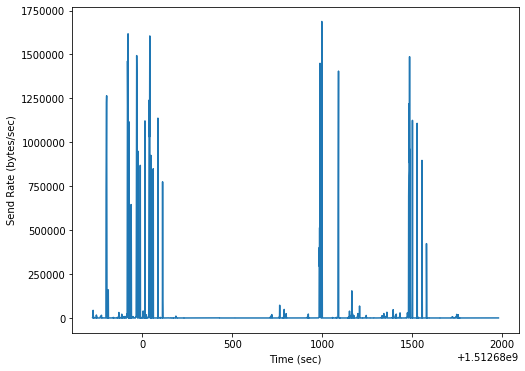

In [42]:
# Define the bin size over which to compute rates
sampling_interval_sec = 1

# Compute the send rates and the time for each bin.
rates, rate_times = send_rates(time_packets, sampling_interval_sec)

plt.plot(rate_times, rates)
plt.ylabel("Send Rate (bytes/sec)")
plt.xlabel("Time (sec)")
plt.show()
#Total amount of data sent over equal lengths of time 